In [1]:
import gc
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

import torch.nn as nn

from tqdm import tqdm

from Data import load_df, ChannelJitter, RandomNoise
from Network import Unet, ssim_loss, ConvolutionBlock, ASPP

path = "datasets/" + "with_labels/"
device = "cuda"

IM = torch.tensor([ 0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5, 0.0]).to(device)

IS = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5, 1.0]).to(device)

df = load_df(path)
#df_z = df[df["mean"] < 0.2].sample(frac=0.2)
#df = pd.concat([df[df["mean"] >= 0.2], df_z])

df.head()

,lat,lon,year,month,day,mean,filename
0,-3.37,-55.14,2017,7,1,0.00,Labeled_-3.37_-55.14_2017_07_01_0.00.npy
1,-3.59,-54.72,2016,8,1,0.60,Labeled_-3.59_-54.72_2016_08_01_0.60.npy
2,-4.01,-54.76,2021,5,1,0.63,Labeled_-4.01_-54.76_2021_05_01_0.63.npy
3,-3.57,-55.06,2020,8,1,0.00,Labeled_-3.57_-55.06_2020_08_01_0.00.npy
4,-3.61,-55.10,2018,8,1,0.00,Labeled_-3.61_-55.10_2018_08_01_0.00.npy


In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, path, positions, df, validaion=False):
        self.img_dir = path

        self.positions = positions.copy()
        self.images = df.copy()

        if validaion:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomCrop((64, 64)),
                transforms.Normalize(IM, IS),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                
                transforms.RandomApply([transforms.RandomRotation(360, interpolation=transforms.InterpolationMode.BILINEAR)], p=0.2),
                
                transforms.RandomCrop((64, 64)),
                transforms.Normalize(IM, IS),
                
                #RandomSimetry(),
                transforms.RandomApply([ChannelJitter(0.2, 0.2)], p=0.2),
                transforms.RandomApply([RandomNoise(0.2)], p=0.2),
            ])

    def __len__(self):
        return self.positions.shape[0]

    def __getitem__(self, idx):
        
        position = self.positions.iloc[idx]
        series = self.images[(self.images["lat"] == position["lat"]) & (self.images["lon"] == position["lon"])]

        filename = series.sample(1)["filename"].values[0]

        img = np.load(self.img_dir + filename)
        img = self.transform(img)

        return img[:-1, :, :].to(device), img[-1, :, :].to(device)

positions = df[["lat", "lon"]].drop_duplicates()

train_positions = positions.sample(frac=0.8)
val_positions   = positions.drop(train_positions.index)

train_ds = SatelliteDataset(path, train_positions, df)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

val_ds = SatelliteDataset(path, val_positions, df, validaion=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)

test_dl = DataLoader(train_ds, batch_size=len(val_ds), shuffle=True)

len(train_ds), len(val_ds)

(1252, 313)

In [3]:
im, lb = next(iter(val_dl))
print(im.mean(dim=[0,2,3]))
print(im.std(dim=[0,2,3]))

tensor([-0.2743, -0.2576, -0.6382, -0.2160, -0.3719, -0.1135, -0.0740,  0.9045,
        -0.2616, -0.2471, -0.6322, -0.2100, -0.4051, -0.1283, -0.0805,  0.8901,
        -0.2830, -0.2736, -0.6686, -0.2417, -0.4899, -0.2045, -0.1380,  0.9267],
       device='cuda:0')
tensor([0.1459, 0.1549, 0.1739, 0.1895, 0.6393, 0.5542, 0.4229, 0.4265, 0.2423,
        0.2440, 0.2456, 0.2569, 0.7071, 0.5807, 0.4485, 0.4557, 0.1014, 0.1087,
        0.1274, 0.1396, 0.5684, 0.4786, 0.3385, 0.3759], device='cuda:0')


In [4]:
#https://www.mdpi.com/2079-9292/11/1/130
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(
            ConvolutionBlock(8, 8, kernel_size=3),
            ConvolutionBlock(8, 8, kernel_size=3, residual=True),

            ASPP(8, 8, residual=True),
        )
        
        self.unet = Unet(8*3, 16, attention=True)

        self.conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            #nn.Sigmoid() # Sigmoid is included in the loss
        )

    def forward(self, x):

        # x shape is (batch, 24, 64, 64)

        # Divide the second channel in x0, x1 and x2
        x0, x1, x2 = torch.split(x, 8, dim=1)
        x0 = self.enc(x0)
        x1 = self.enc(x1)
        x2 = self.enc(x2)

        # Concatenate the three channels
        x = torch.cat([x0, x1, x2], dim=1)

        x = self.unet(x)
        x = self.conv(x)

        if not self.training:
            x *= 100000

        return x

model = Network().to(device)

In [5]:
Mean = df["mean"].mean()

bce_loss = nn.BCEWithLogitsLoss()
bce_ssim = lambda output, target: bce_loss(output, target) + 2 * ssim_loss(torch.sigmoid(output), target)

In [6]:
def plot_images():
    model.eval()

    im, lb = next(iter(val_dl))
    lb = lb[:, None, ...]
    out = torch.sigmoid(model(im))

    im0 = (im[0][3:6] * IS[3:6, None, None]) + IM[3:6, None, None]
    im0 = im0.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im1 = (im[0][11:14] * IS[11:14, None, None]) + IM[11:14, None, None]
    im1 = im1.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im2 = (im[0][19:22] * IS[19:22, None, None]) + IM[19:22, None, None]
    im2 = im2.permute(1, 2, 0).clip(0,1).cpu().numpy()

    label = lb[0][0].cpu().numpy()
    output = out[0][0].detach().cpu().numpy()

    fig, axes = plt.subplots(1, 5, figsize=(15, 10))
    axes[0].imshow(im0)
    axes[1].imshow(im1)
    axes[2].imshow(im2)
    axes[3].imshow(label)
    axes[4].imshow(output)
    plt.show()

    model.train()

In [7]:
def f1_score(dl):
    model.eval()

    im, lb = next(iter(dl))

    label = lb[:, None, ...]
    output = torch.sigmoid(model(im))

    tp = torch.sum(output * label)
    fp = torch.sum(output * (1-label))
    fn = torch.sum((1-output) * label)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    
    union = tp + fp + fn
    iou = tp / union # recall / (recall + 1) ?
    
    model.train()

    return float(f1), float(iou)

  0%|          | 0/10001 [00:00<?, ?it/s]

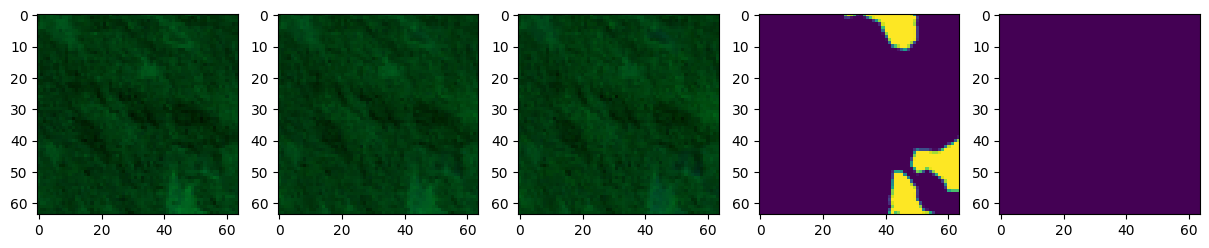

Loss: 1.2633:   2%|▏         | 200/10001 [00:14<10:17, 15.87it/s]

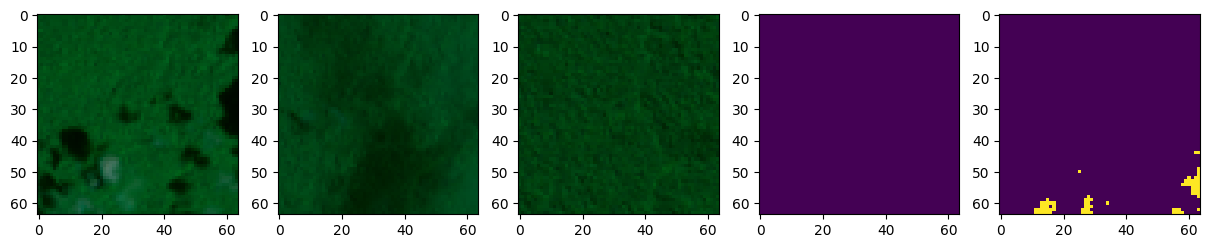

Loss: 1.3871:   4%|▍         | 400/10001 [00:29<10:02, 15.93it/s]

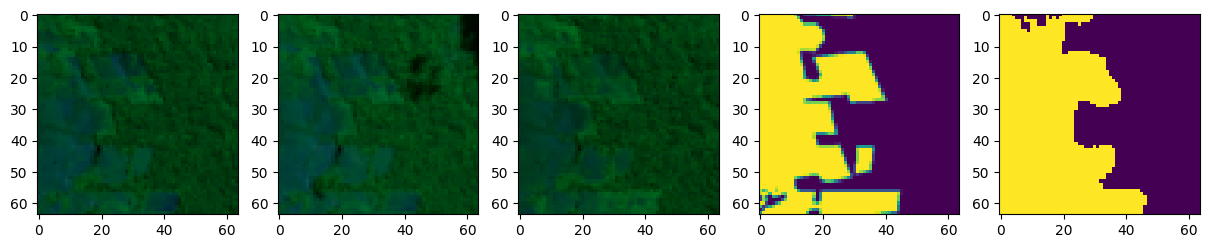

Loss: 1.3127:   6%|▌         | 600/10001 [00:43<09:54, 15.82it/s]

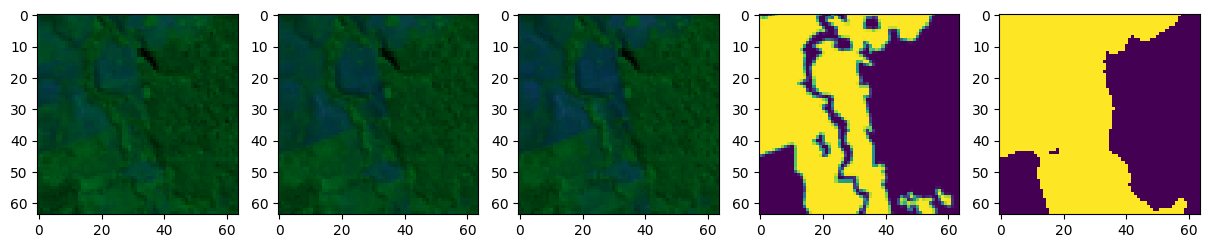

Loss: 1.1777:   8%|▊         | 800/10001 [00:57<10:08, 15.11it/s]

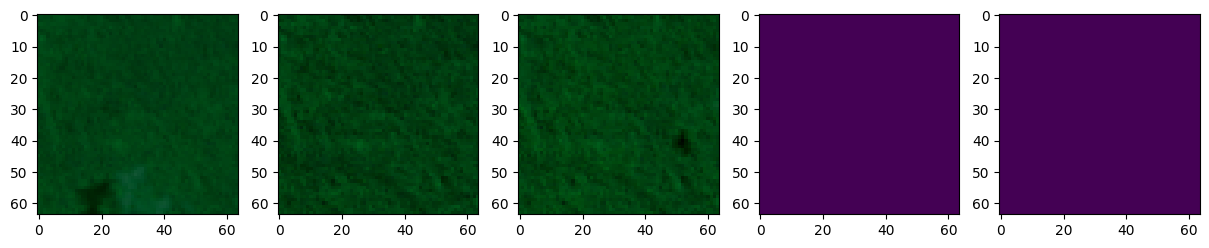

Loss: 1.5000:  10%|▉         | 1000/10001 [01:12<09:35, 15.64it/s]

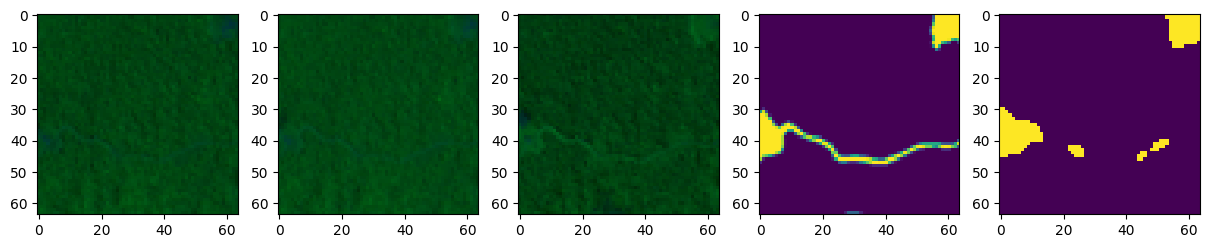

Loss: 1.3016:  12%|█▏        | 1200/10001 [01:26<09:24, 15.60it/s]

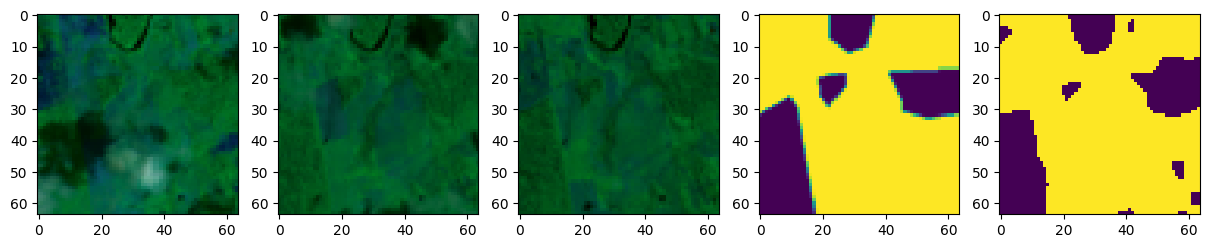

Loss: 1.2800:  14%|█▍        | 1400/10001 [01:41<09:05, 15.75it/s]

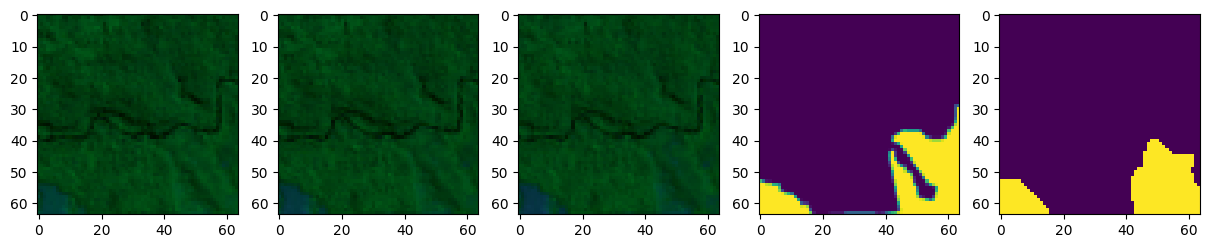

Loss: 1.2298:  16%|█▌        | 1600/10001 [01:55<08:52, 15.79it/s]

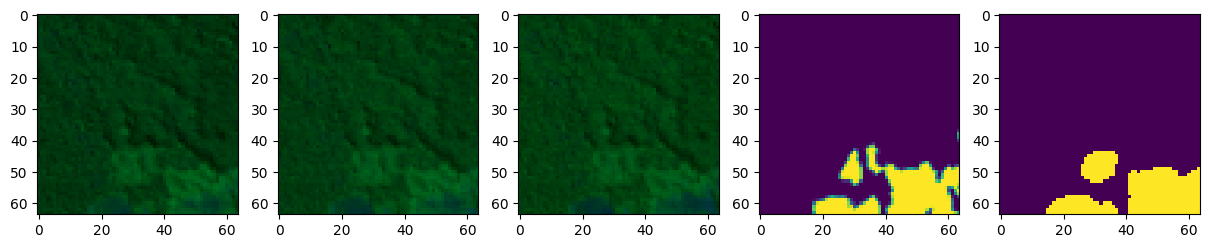

Loss: 1.0250:  18%|█▊        | 1800/10001 [02:10<08:53, 15.37it/s]

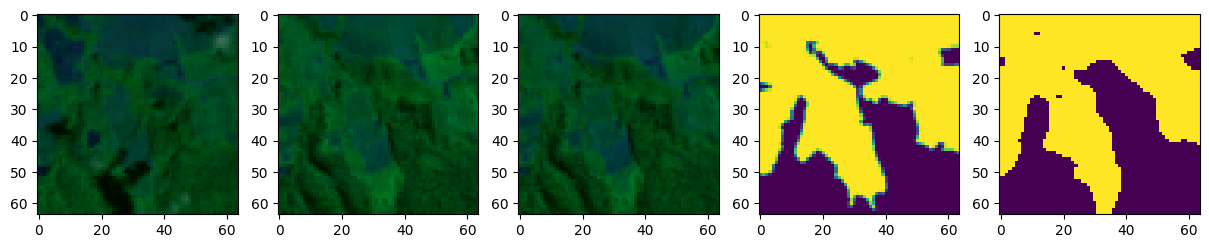

Loss: 1.1094:  20%|█▉        | 2000/10001 [02:24<08:29, 15.70it/s]

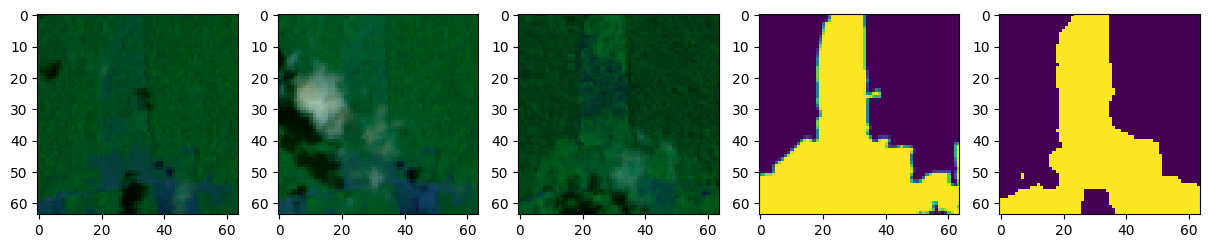

Loss: 0.8963:  22%|██▏       | 2200/10001 [02:38<08:13, 15.81it/s]

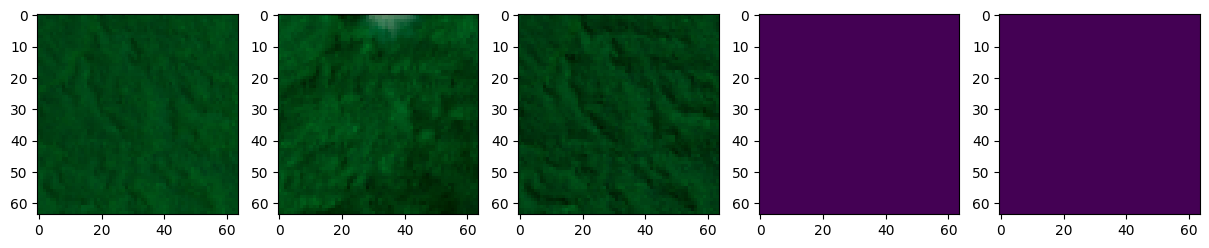

Loss: 1.2268:  24%|██▍       | 2400/10001 [02:53<08:01, 15.79it/s]

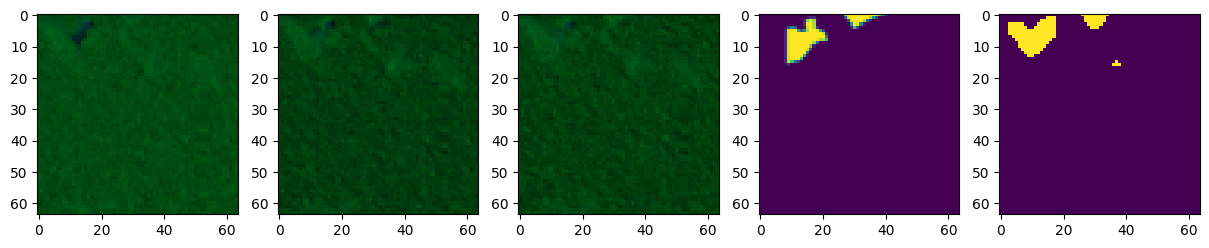

Loss: 1.1110:  26%|██▌       | 2600/10001 [03:07<07:46, 15.87it/s]

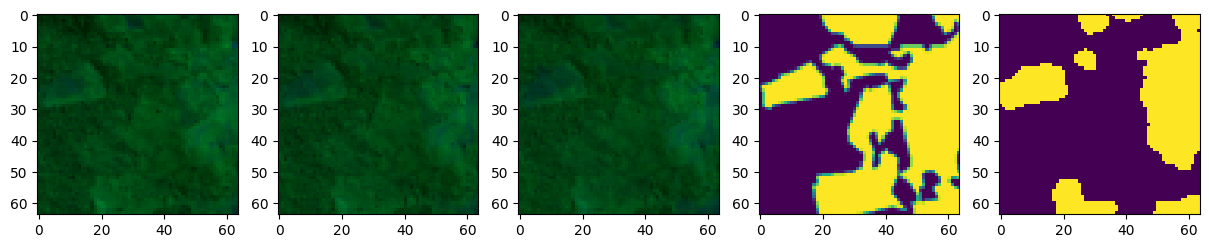

Loss: 1.1107:  28%|██▊       | 2800/10001 [03:22<08:15, 14.53it/s]

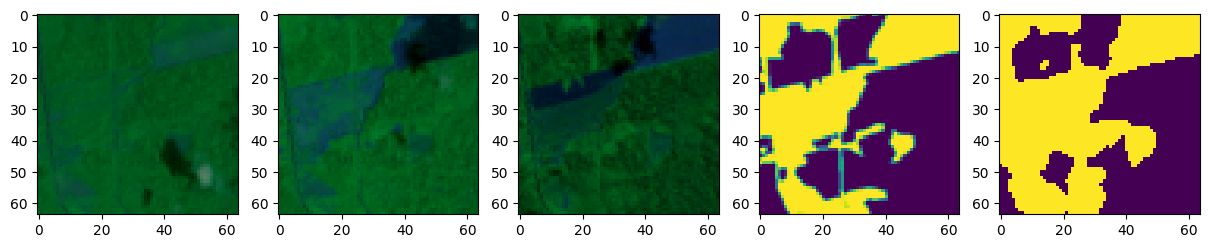

Loss: 1.1594:  30%|██▉       | 3000/10001 [03:36<07:29, 15.59it/s]

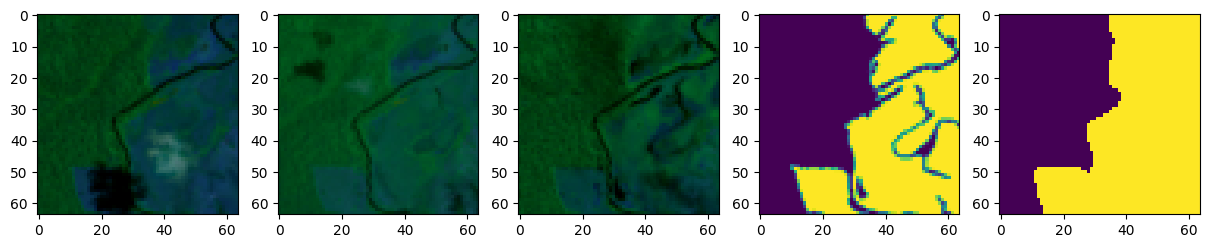

Loss: 1.0104:  32%|███▏      | 3200/10001 [03:51<07:19, 15.47it/s]

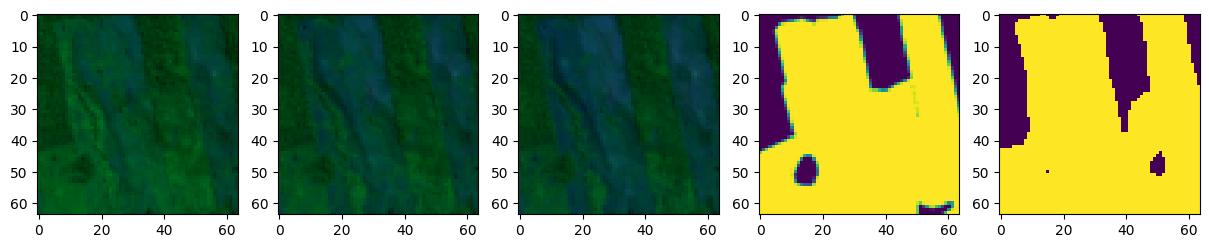

Loss: 1.0349:  34%|███▍      | 3400/10001 [04:05<07:01, 15.68it/s]

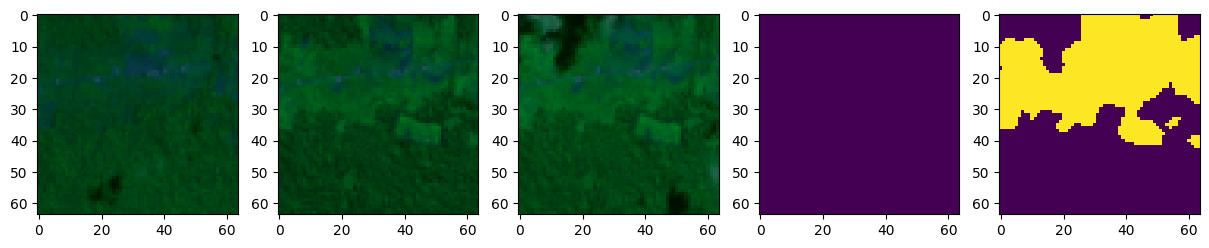

Loss: 1.0443:  36%|███▌      | 3600/10001 [04:20<06:48, 15.67it/s]

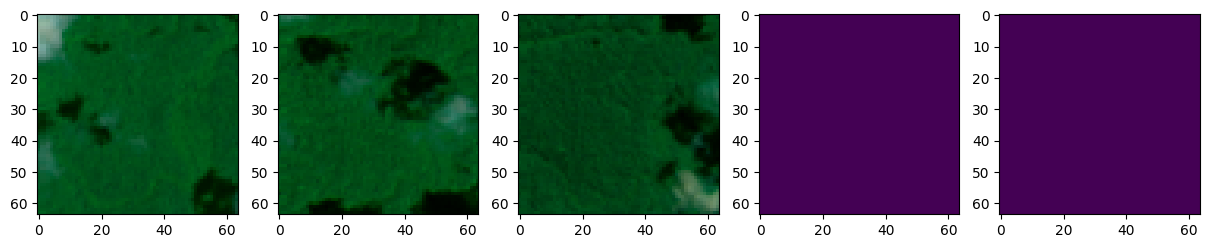

Loss: 1.1225:  38%|███▊      | 3800/10001 [04:34<06:38, 15.55it/s]

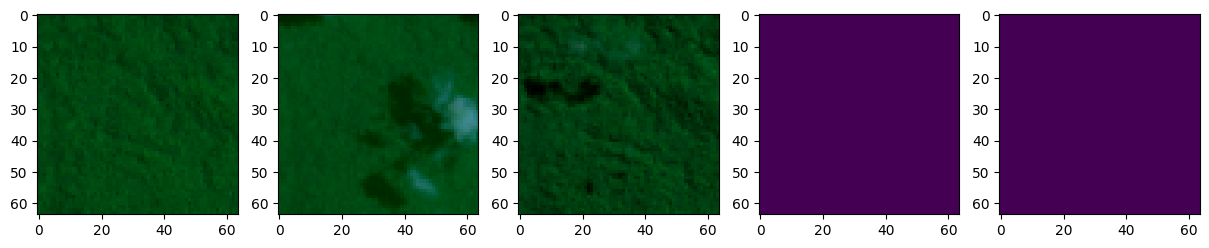

Loss: 0.8050:  40%|███▉      | 4000/10001 [04:48<06:23, 15.66it/s]

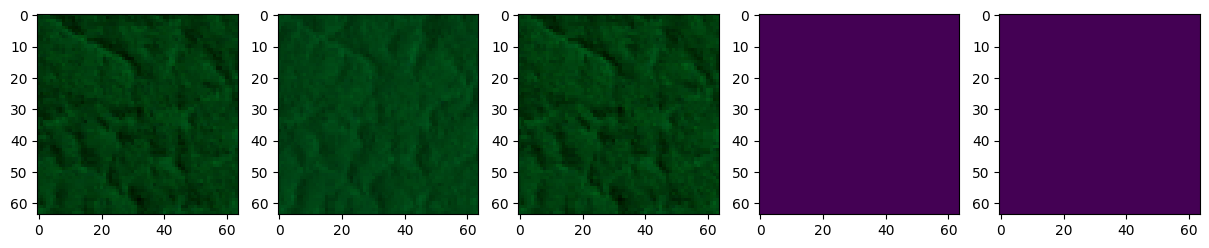

Loss: 1.1199:  42%|████▏     | 4200/10001 [05:03<06:08, 15.73it/s]

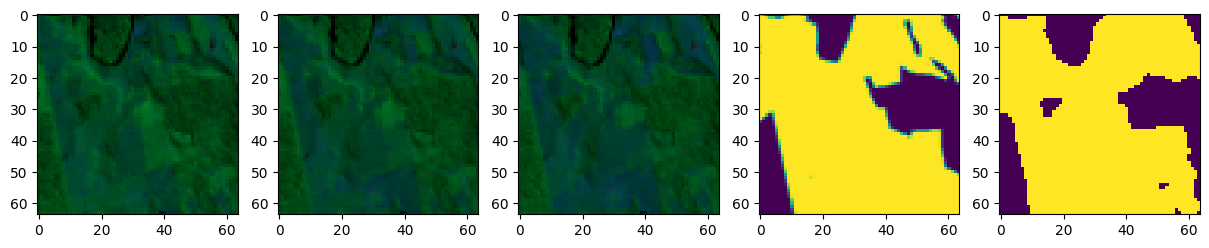

Loss: 1.0120:  44%|████▍     | 4400/10001 [05:17<05:54, 15.80it/s]

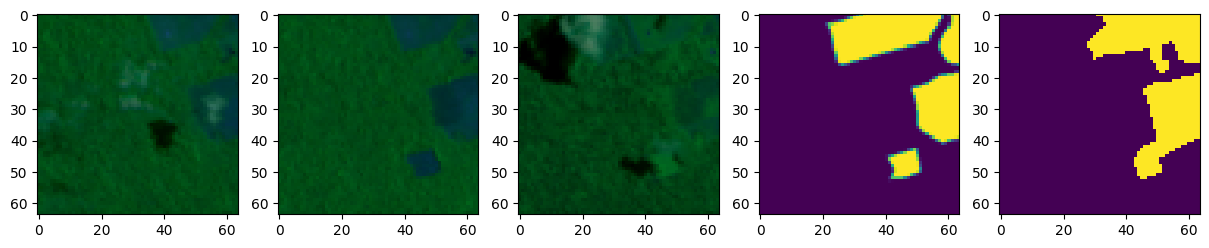

Loss: 1.1512:  46%|████▌     | 4600/10001 [05:32<05:43, 15.74it/s]

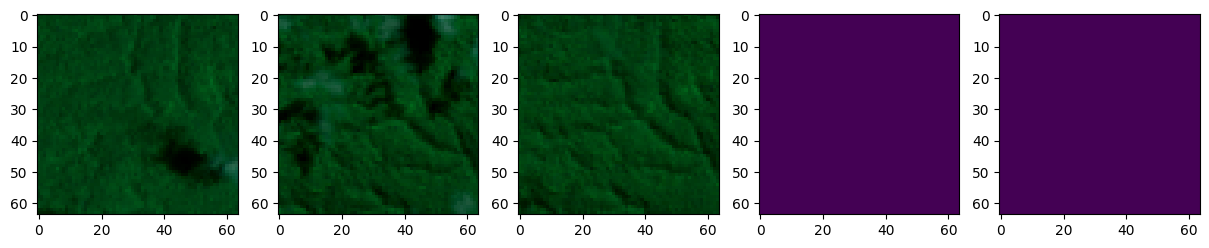

Loss: 0.8699:  48%|████▊     | 4800/10001 [05:46<05:30, 15.74it/s]

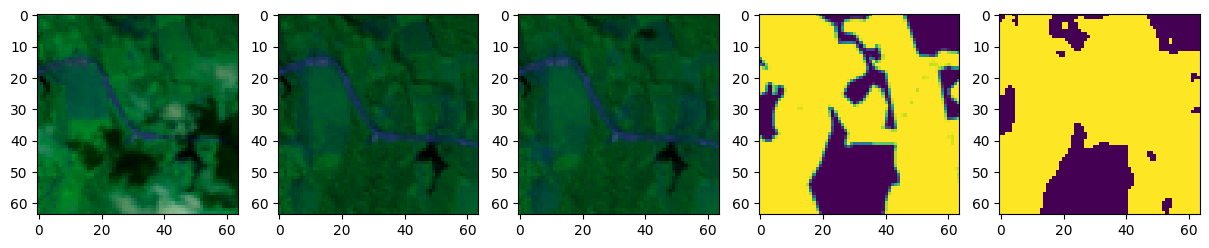

Loss: 0.9478:  50%|████▉     | 5000/10001 [06:01<05:13, 15.94it/s]

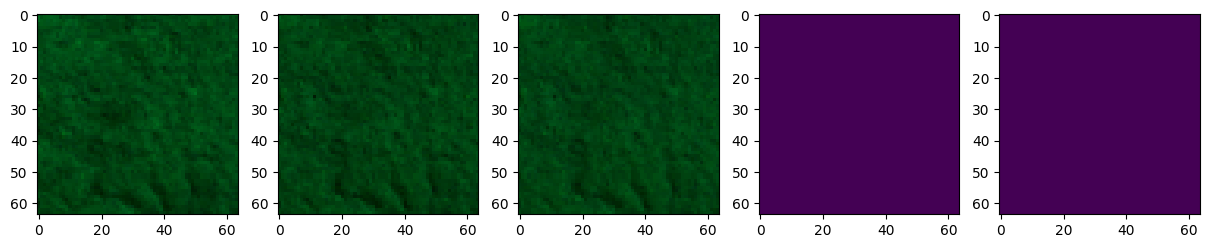

Loss: 1.1358:  52%|█████▏    | 5200/10001 [06:15<05:06, 15.64it/s]

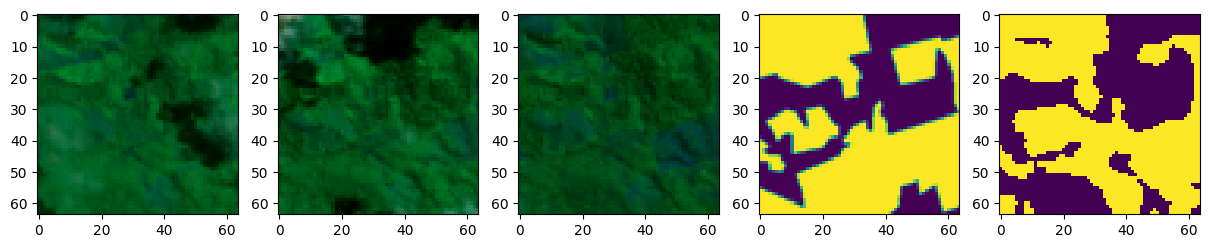

Loss: 1.0393:  54%|█████▍    | 5400/10001 [06:29<04:52, 15.75it/s]

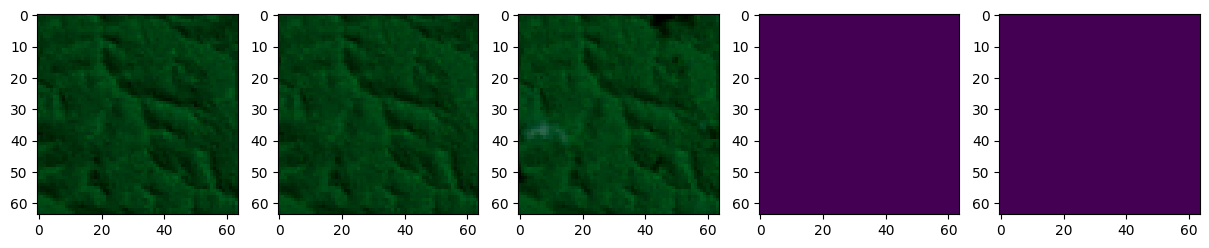

Loss: 0.9072:  56%|█████▌    | 5600/10001 [06:44<04:39, 15.72it/s]

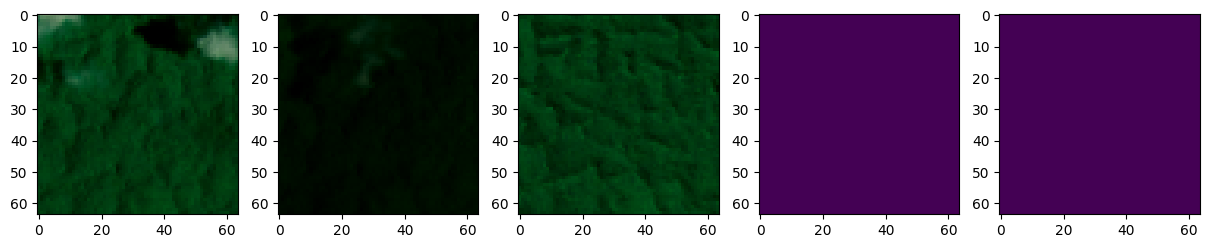

Loss: 0.9086:  58%|█████▊    | 5800/10001 [06:58<04:49, 14.53it/s]

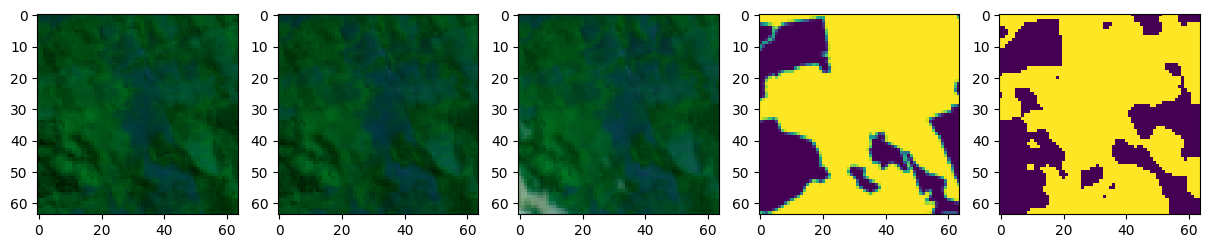

Loss: 1.1659:  60%|█████▉    | 6000/10001 [07:13<04:13, 15.76it/s]

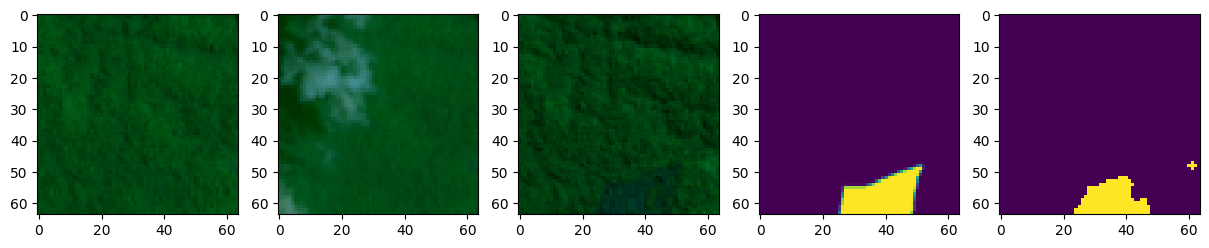

Loss: 1.0615:  62%|██████▏   | 6200/10001 [07:27<04:00, 15.82it/s]

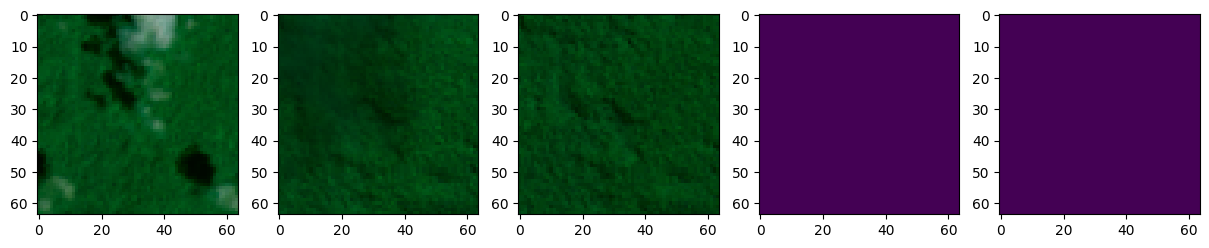

Loss: 0.9799:  64%|██████▍   | 6400/10001 [07:42<03:46, 15.87it/s]

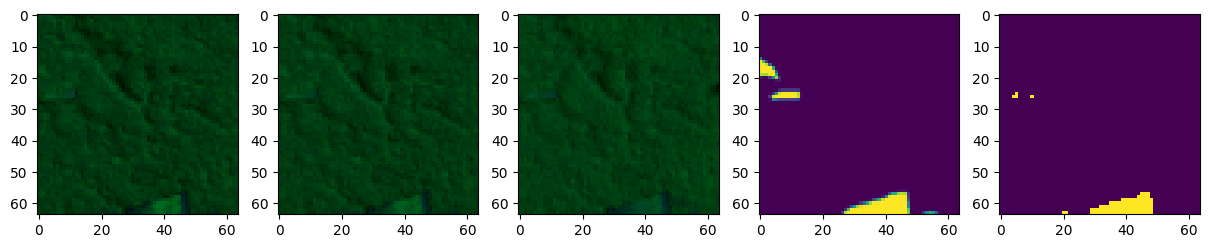

Loss: 1.0677:  66%|██████▌   | 6600/10001 [07:56<03:36, 15.69it/s]

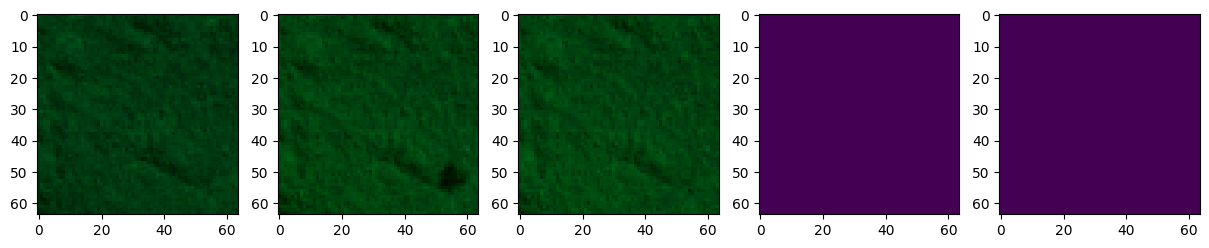

Loss: 0.7570:  68%|██████▊   | 6800/10001 [08:10<03:25, 15.59it/s]

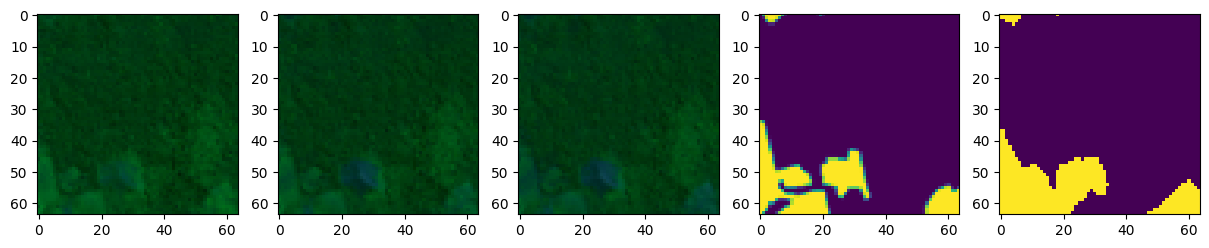

Loss: 1.0190:  70%|██████▉   | 7000/10001 [08:25<03:09, 15.82it/s]

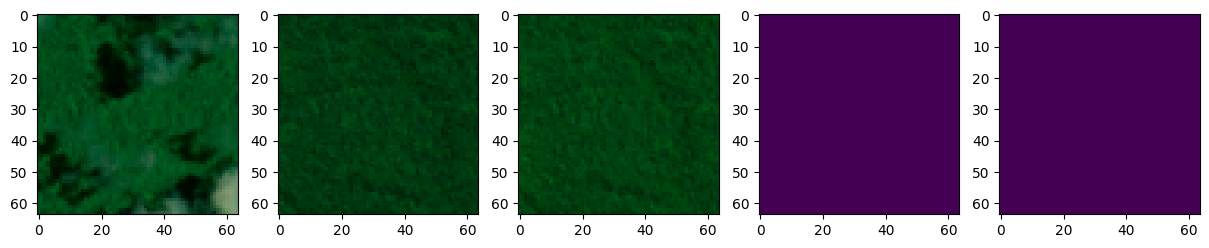

Loss: 0.8409:  72%|███████▏  | 7200/10001 [08:39<02:58, 15.70it/s]

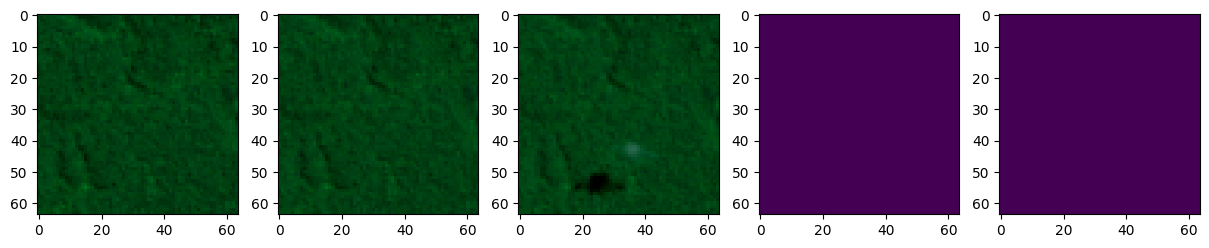

Loss: 0.9137:  74%|███████▍  | 7400/10001 [08:54<02:44, 15.77it/s]

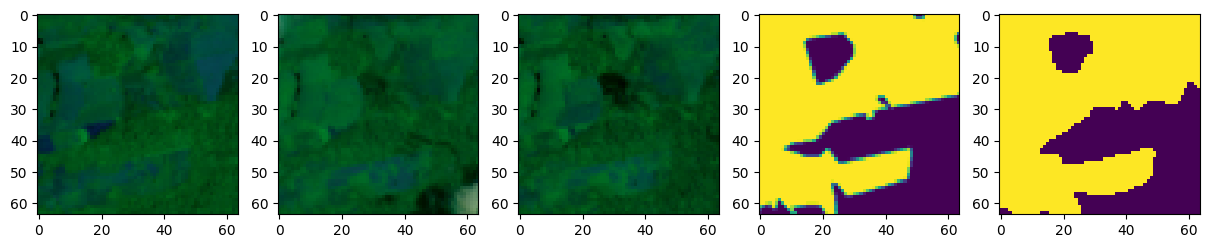

Loss: 1.2660:  76%|███████▌  | 7600/10001 [09:08<02:33, 15.60it/s]

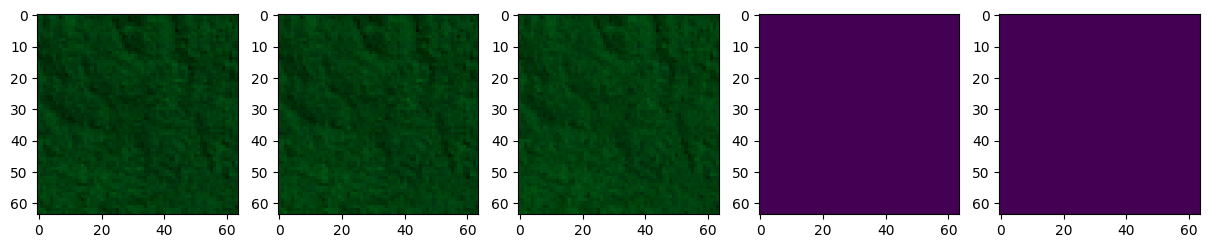

Loss: 1.1566:  78%|███████▊  | 7800/10001 [09:22<02:19, 15.75it/s]

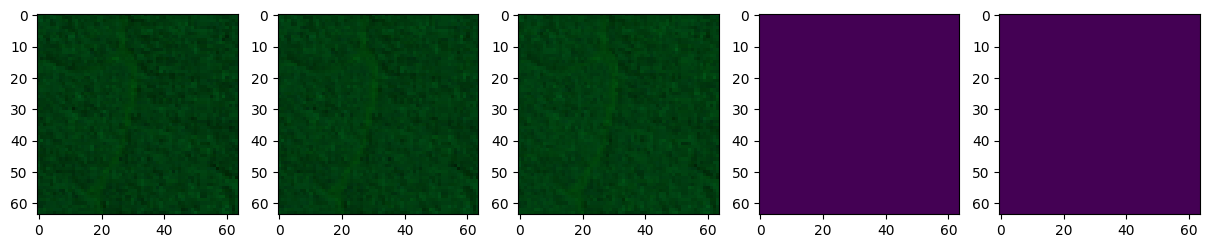

Loss: 0.8421:  80%|███████▉  | 8000/10001 [09:37<02:09, 15.46it/s]

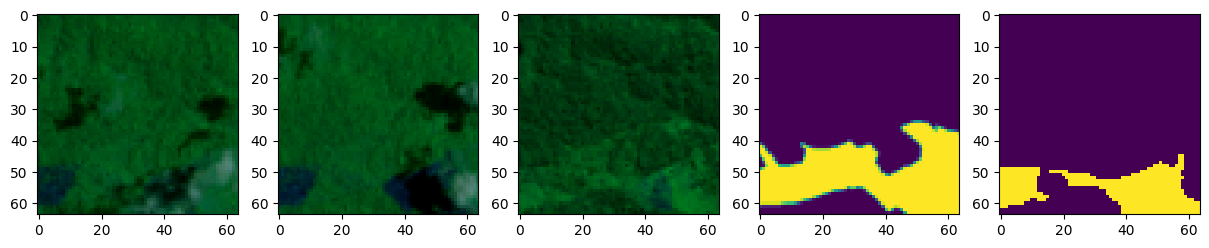

Loss: 1.2749:  82%|████████▏ | 8200/10001 [09:51<01:54, 15.67it/s]

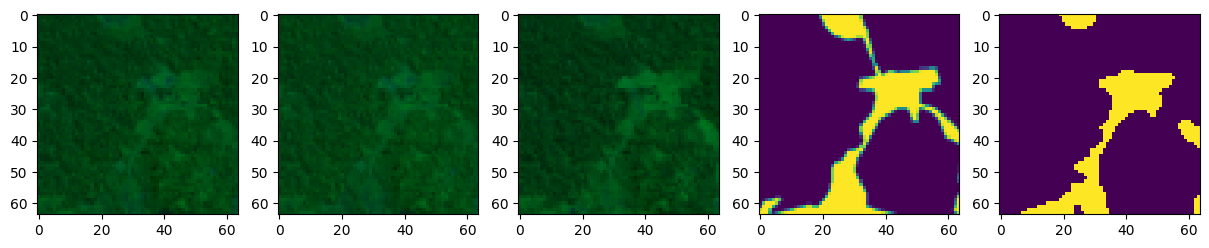

Loss: 1.0541:  84%|████████▍ | 8400/10001 [10:06<01:41, 15.74it/s]

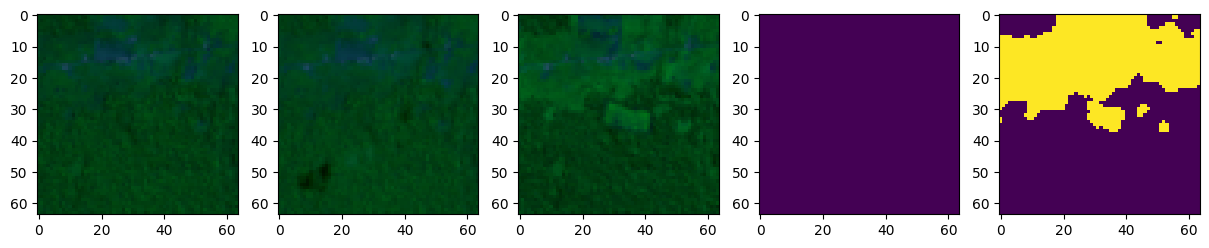

Loss: 0.9402:  86%|████████▌ | 8600/10001 [10:20<01:28, 15.91it/s]

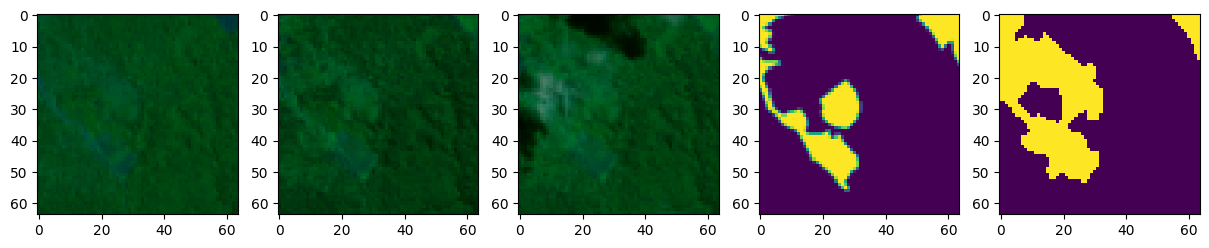

Loss: 1.0110:  88%|████████▊ | 8800/10001 [10:35<01:17, 15.59it/s]

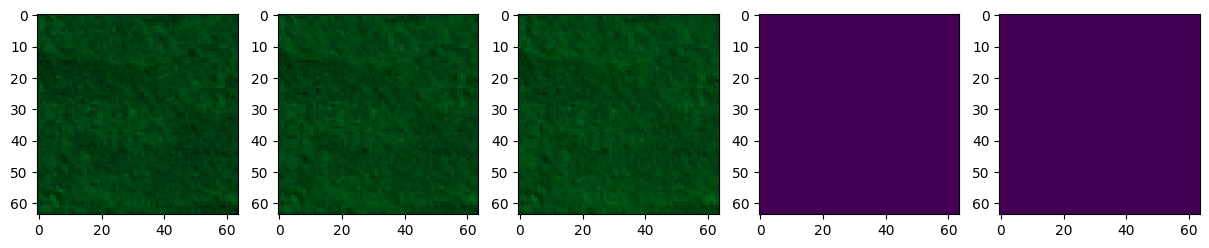

Loss: 0.9849:  90%|████████▉ | 9000/10001 [10:49<01:03, 15.73it/s]

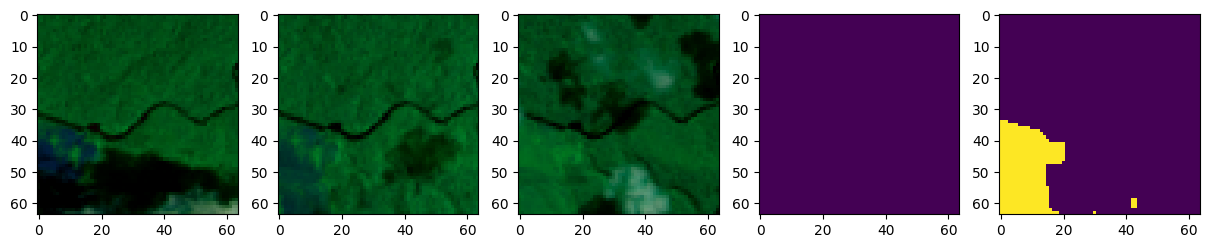

Loss: 0.9297:  92%|█████████▏| 9200/10001 [11:04<00:50, 15.71it/s]

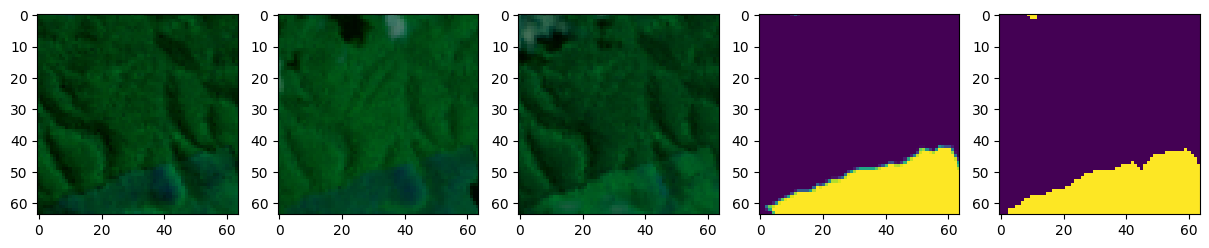

Loss: 0.8373:  94%|█████████▍| 9400/10001 [11:18<00:38, 15.67it/s]

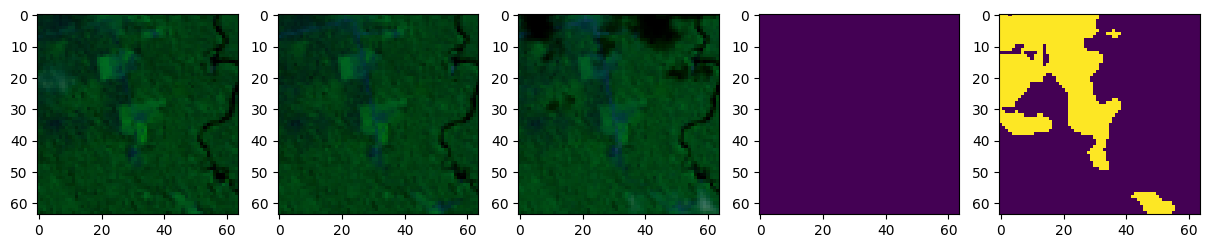

Loss: 1.0477:  96%|█████████▌| 9600/10001 [11:33<00:25, 15.67it/s]

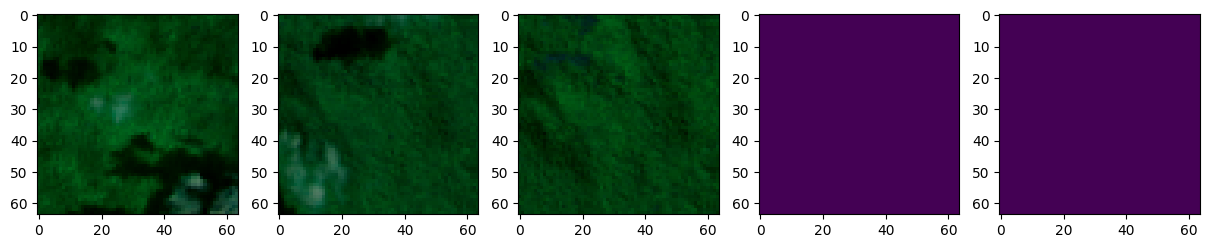

Loss: 0.8444:  98%|█████████▊| 9800/10001 [11:47<00:12, 15.70it/s]

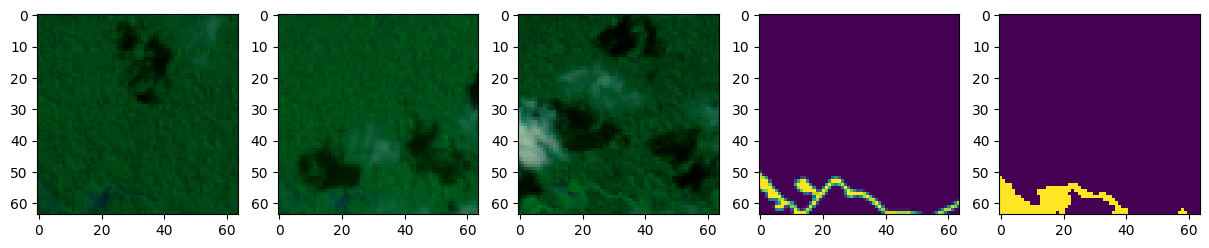

Loss: 0.8262: 100%|█████████▉| 10000/10001 [12:01<00:00, 15.62it/s]

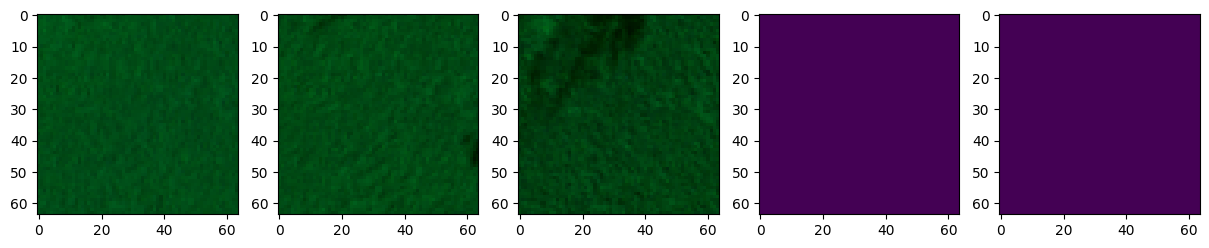

Loss: 1.1011: 100%|██████████| 10001/10001 [12:03<00:00, 13.82it/s]


In [8]:
model.train()
loss_fn = bce_ssim
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

pbar = tqdm(range(20001), miniters=5)
def closure():
    global pbar, optimizer, loss_fn

    optimizer.zero_grad()

    im, lb = next(iter(train_dl))
    lb = lb[:, None, ...]

    out = model(im)
    loss = loss_fn(out, lb).mean()
    
    loss.backward()

    pbar.set_description(f"Loss: {loss:.4f}", refresh=False)
    return loss

val_losses = []
train_losses = []

model.train()
for i in pbar:
    if i == 2500:
        #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = bce_ssim

    if i % 200 == 0:
        with torch.no_grad():
            #gc.collect()
            #torch.cuda.empty_cache()

            if i % 200 == 0:
                plot_images()
                #gc.collect()
                #torch.cuda.empty_cache()
            
            val_losses.append(f1_score(val_dl))
            #gc.collect()
            #torch.cuda.empty_cache()

            train_losses.append(f1_score(test_dl))        
            #gc.collect()
            #torch.cuda.empty_cache()

    optimizer.step(closure)

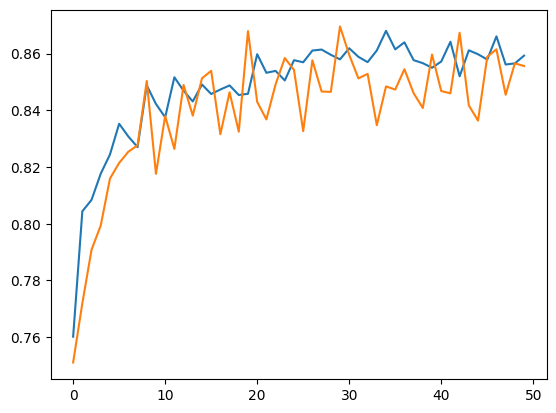

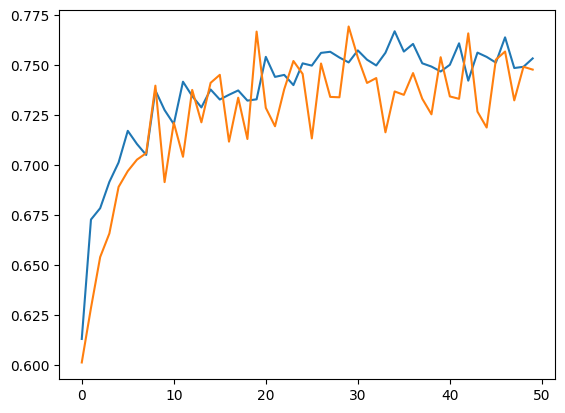

In [9]:
val_f1 = [x[0] for x in val_losses]
val_iou = [x[1] for x in val_losses]

train_f1 = [x[0] for x in train_losses]
train_iou = [x[1] for x in train_losses]

# plot val_losses, train_losses on the same plot
plt.plot(val_f1[1:]) # azul
plt.plot(train_f1[1:]) # laranja
plt.show()

plt.plot(val_iou[1:]) # azul
plt.plot(train_iou[1:]) # laranja
plt.show()

0.8593973159790039


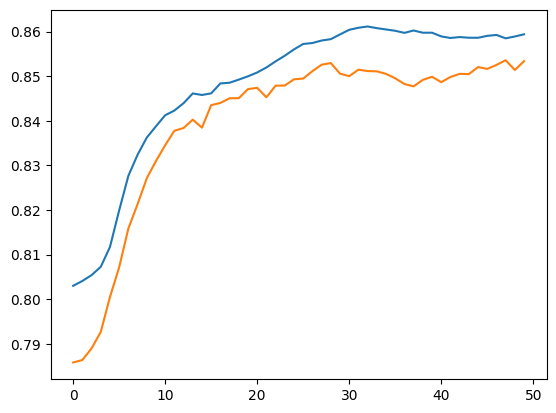

In [10]:
from scipy.ndimage import uniform_filter1d

aa = np.array(val_f1[1:])
aa = uniform_filter1d(aa, size=10)
plt.plot(aa)
print(aa[-1])

aa = np.array(train_f1[1:])
aa = uniform_filter1d(aa, size=10)
plt.plot(aa)